In [1]:
import os
import zipfile
import re
import pandas as pd
import numpy as np
import cv2
from datetime import datetime

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
#os.environ.keys()

##### Building the dataset for the attributed provides

In [4]:
DATA_DIR = "/home/jupyter/work/data/"
#DATA_DIR = "d:/GoogleDrive/Machine Learning Datasets and models/datasets/CelebA/"
ANNOTATION_DIR = "Anno-20200428T062856Z-001/Anno/"
ANNOTATION_FILE = "list_attr_celeba.txt"
EVAL_DIR = "Eval-20200428T063027Z-001/Eval/"
EVAL_FILE = "list_eval_partition.txt"
IMG_DIR = "celeb_data/train/"

##### Details about annotation file
```
- Attributes Annotations (Anno/list_attr_celeba.txt)
	40 binary attribute labels. See ATTRIBUTE LABELS section below for 
    more info.
=========================
ATTRIBUTE LABELS
=========================
--------------- list_attr_celeba.txt --------------
First Row: number of images
Second Row: attribute names

Rest of the Rows: <image_id> <attribute_labels>
---------------------------------------------------
Notes:
1. The order of attribute labels accords with the order of attribute names;
2. In attribute labels, "1" represents positive while "-1" represents negative.
---------------------------------------------------
```

In [5]:
with open(DATA_DIR + ANNOTATION_DIR + ANNOTATION_FILE,"r") as f:
    anno_file_data = f.readlines()
print("Total lines read : ",len(anno_file_data))

Total lines read :  202601


In [6]:
print(anno_file_data[0],anno_file_data[1])

202599
 5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young 



In [7]:
total_images = int(anno_file_data[0])
column_names = anno_file_data[1].split(" ")[:-1] # last is \n character so ignoring that #

In [8]:
# Building a data frame for annotation data
anno_data_pd = pd.DataFrame([re.sub("\s+"," ",anno_file_data[x]).split(" ")[:-1] for x in range(2,len(anno_file_data))],
                            columns=["filename"] + column_names)

In [9]:
anno_data_pd.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [10]:
# Convering +1/-1 to dtype int #
anno_data_pd = pd.concat([anno_data_pd.iloc[:,0],anno_data_pd.iloc[:,1:].astype(int)],axis=1)

In [11]:
# Reading training/ validation / testing data information #
with open(DATA_DIR + EVAL_DIR + EVAL_FILE,"r") as f:
    eval_data = f.readlines()

In [12]:
eval_data_pd = pd.DataFrame([eval_data[x][:-1].split(" ") for x in range(len(eval_data))],columns=["filename","train_val_test"])

In [13]:
eval_data_pd.head()

,filename,train_val_test
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [14]:
anno_data_pd = pd.merge(left=anno_data_pd, right=eval_data_pd,left_on="filename",right_on="filename",how="left")

In [15]:
anno_data_pd = anno_data_pd.assign(train_val_test = anno_data_pd.train_val_test.map({"0" : "train",
                                                                                     "1" : "validation",
                                                                                     "2" : "test"}))

In [16]:
anno_data_pd.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,train_val_test
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,train
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,train
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,train
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,train
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,train


In [17]:
img = cv2.imread(DATA_DIR + IMG_DIR + "000001.jpg")
img.shape

(218, 178, 3)

In [18]:
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, MaxPool2D, Dense,Input, Flatten, Reshape, Lambda, LeakyReLU, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# For plotting model graph
from tensorflow.keras.utils import plot_model

In [19]:
vgg19_model = VGG19(weights="imagenet",include_top=False)
vgg19_model.trainable = False

In [20]:
vgg19_model.predict(img.reshape(1,218,178,3)).shape

(1, 6, 5, 512)

#### Building the Encoder Model

In [21]:
embedding_dim = 128

In [22]:
# Get VGG's last layer output #
vgg19_output = vgg19_model.get_layer("block5_pool").output

# Reshape it as per sample output shape seen above
vgg19_output = Reshape((15360,),name="encoder_reshape_layer")(vgg19_output)

# Building the mean layer
mu_output = Dense(embedding_dim,name="mu_layer")(vgg19_output)

# building the log_var layer
log_var_output = Dense(embedding_dim,name="log_var_layer")(vgg19_output)

# sampling from a standard normal distribution, forcing the representation
def sampling(args):
    mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mu), mean=0, stddev=1.0)
    return mu + K.exp(log_var/2) * epsilon

encoder_output = Lambda(sampling,name="encoder_output")([mu_output,log_var_output])

In [23]:
mu_log_var_model = Model(inputs=vgg19_model.input,outputs=[mu_output,log_var_output])

In [24]:
encoder_model = Model(inputs=vgg19_model.input, outputs=encoder_output)

#### Building the decoder

In [25]:
img.shape

(218, 178, 3)

In [26]:
decoder_input = Input(shape=(embedding_dim,),name="decoder_input")
x = decoder_input
x = Dense(15360,name="decoder_dense")(decoder_input)
x = Reshape((6,5,512),name="decoder_reshape")(x)

x = Conv2DTranspose(512,strides=2,kernel_size=(2,2),name="decoder_blk-1_2dtran-1")(x)           # output (12,10)
x = LeakyReLU()(x)
x = Conv2DTranspose(512,strides=1,kernel_size=(2,2),name="decoder_blk-1_2dtran-2")(x)           # output (13,11)
x = LeakyReLU()(x)
x = Conv2DTranspose(512,strides=2,kernel_size=(2,2),name="decoder_blk-1_2dtran-3")(x)           # output (26,22)
x = LeakyReLU()(x)

# Special group, to increase the size of 1 axis - same channel #
x = Conv2DTranspose(512,strides=1,kernel_size=(2,1),name="decoder_blk-sp_2dtran-1")(x)           # output (27,22)
x = LeakyReLU()(x)

# Reduce channel - same size
x = Conv2DTranspose(256,strides=1,kernel_size=(1,1),name="decoder_blk-2_2dtran-1")(x)           # output (27,22)
x = LeakyReLU()(x)
# Reduce channel - same size
x = Conv2DTranspose(128,strides=1,kernel_size=(1,1),name="decoder_blk-2_2dtran-2")(x)           # output (27,22)
x = LeakyReLU()(x)
# Same Channel - increase size
x = Conv2DTranspose(128,strides=2,kernel_size=(2,2),name="decoder_blk-2_2dtran-3")(x)           # output (54,44)
x = LeakyReLU()(x)

# Reduce channel - same size
x = Conv2DTranspose(64,strides=1,kernel_size=(1,1),name="decoder_blk-3_2dtran-1")(x)           # output (54,44)
x = LeakyReLU()(x)
# Reduce channel - same size
x = Conv2DTranspose(32,strides=1,kernel_size=(1,1),name="decoder_blk-3_2dtran-2")(x)           # output (54,44)
x = LeakyReLU()(x)
# Same Channel - increase size
x = Conv2DTranspose(32,strides=2,kernel_size=(2,2),name="decoder_blk-3_2dtran-3")(x)           # output (108,88)
x = LeakyReLU()(x)

# Special group, to increase the size of 1 axis - same channel #
x = Conv2DTranspose(32,strides=1,kernel_size=(2,2),name="decoder_blk-sp_2dtran-2")(x)           # output (109,89)
x = LeakyReLU()(x)

# Reduce Channel - same size
x = Conv2DTranspose(16,strides=1,kernel_size=(1,1),name="decoder_blk-4_2dtran-1")(x)           # output (109,89)
x = LeakyReLU()(x)
# Reduce channel - same size
x = Conv2DTranspose(8,strides=1,kernel_size=(1,1),name="decoder_blk-4_2dtran-2")(x)            # output (109,89)
x = LeakyReLU()(x)
# Same Channel - increase size
x = Conv2DTranspose(8,strides=2,kernel_size=(2,2),name="decoder_blk-4_2dtran-3")(x)           # output (218,178)
x = LeakyReLU()(x)
# Reduce channel - same size
x = Conv2DTranspose(3,strides=1,kernel_size=(1,1),name="decoder_blk-4_2dtran-4")(x)           # output (218,178)

# final activation
x = Activation("sigmoid")(x)
decoder_output = x

In [27]:
decoder_model = Model(inputs=decoder_input,outputs=decoder_output)

In [28]:
complete_input = encoder_model.input
complete_output = decoder_model(encoder_model.output)
complete_model = Model(inputs=complete_input,outputs=complete_output)

In [29]:
complete_model.load_weights("vae_vgg19_2020-05-0603_36_48.943951/model-00005-387.11960-314.58344-418.52588-344.80249.h5")

In [30]:
#plot_model(complete_model,expand_nested=True,show_shapes=True)

In [31]:
#LEARNING_RATE = 0.0005
#R_LOSS_FACTOR = 10000

#model_name = "vae_vgg19"
#reduce_LR_patience = 5
#curr_dt_time = datetime.now()

In [32]:
def vae_r_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return R_LOSS_FACTOR * r_loss

def vae_kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var_output - K.square(mu_output) - K.exp(log_var_output), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true,y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return  r_loss + kl_loss

#complete_model.compile(optimizer=Adam(lr=LEARNING_RATE),
#                       loss=vae_loss,
#                       metrics=[vae_r_loss,vae_kl_loss],
#                       experimental_run_tf_function=False)

In [33]:
#model_name = model_name + "_" + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#if not os.path.exists(model_name):
#    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{vae_r_loss:.5f}-{val_loss:.5f}-{val_vae_r_loss:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, 
#                             monitor='val_loss', 
#                             verbose=1, 
#                             save_best_only=False, 
#                             save_weights_only=False, 
#                             mode='auto', period=1)

#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                       patience=reduce_LR_patience, min_lr=0.001,verbose=1)

#callbacks_list = [checkpoint, LR]
#callbacks_list = [checkpoint]
#callbacks_list = []
#print(model_name)

In [34]:
k_data_gen = image.ImageDataGenerator(rescale=1/255)

In [36]:
train_gen = k_data_gen.flow_from_dataframe(dataframe=anno_data_pd[anno_data_pd.train_val_test == 'train'].iloc[0:50000,:][["filename"]],
                                           directory=DATA_DIR + IMG_DIR,
                                           class_mode="input",
                                           batch_size=32,
                                           shuffle=True,
                                           seed=42,
                                           target_size=(img.shape[0],img.shape[1]))

Found 50000 validated image filenames.


In [37]:
val_gen = k_data_gen.flow_from_dataframe(dataframe=anno_data_pd[anno_data_pd.train_val_test == 'validation'].iloc[0:10000,:][["filename"]],
                                           directory=DATA_DIR + IMG_DIR,
                                           class_mode="input", # we want the output image to same as input image
                                           batch_size=32,
                                           shuffle=True,
                                           seed=42,
                                           target_size=(img.shape[0],img.shape[1]))

Found 10000 validated image filenames.


In [35]:
img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])

In [36]:
img = img / 255

In [37]:
img[0,:,:,:].min(), img[0,:,:,:].max()

(0.0, 1.0)

In [38]:
img.shape

(1, 218, 178, 3)

In [39]:
img_pred = complete_model.predict(img)

In [40]:
img_pred

array([[[[0.9279378 , 0.85650617, 0.88251644],
         [0.83048445, 0.8968663 , 0.90981096],
         [0.933614  , 0.9457413 , 0.94712377],
         ...,
         [0.7272352 , 0.76450646, 0.77043104],
         [0.66485107, 0.688734  , 0.6805718 ],
         [0.7366144 , 0.71159434, 0.70075476]],

        [[0.8946844 , 0.93419635, 0.9202775 ],
         [0.91752106, 0.93378466, 0.9479212 ],
         [0.92465186, 0.9453775 , 0.9541769 ],
         ...,
         [0.7167235 , 0.7487958 , 0.74814945],
         [0.7071863 , 0.7139701 , 0.7049193 ],
         [0.7055771 , 0.7030685 , 0.6883825 ]],

        [[0.94995314, 0.95132846, 0.9571307 ],
         [0.9380917 , 0.95506674, 0.96405923],
         [0.93585914, 0.9477403 , 0.95233124],
         ...,
         [0.7254906 , 0.7575205 , 0.7742353 ],
         [0.7165964 , 0.7467417 , 0.75076145],
         [0.7035546 , 0.7427592 , 0.74900264]],

        ...,

        [[0.5417211 , 0.4412067 , 0.37742266],
         [0.5313986 , 0.43559036, 0.37458462]

In [41]:
encoder_model.predict(img)

array([[ 0.89827085, -0.39131367,  0.05748253,  0.46531957, -0.9240152 ,
         0.71122026, -1.3175426 ,  0.5077841 ,  0.1270917 ,  0.8273955 ,
         0.7248225 , -1.0851462 ,  1.7826978 , -0.08336301, -1.7924752 ,
        -0.19846037, -0.22024891, -0.9867203 , -1.6063647 , -0.7151195 ,
        -1.3937871 , -0.96745557, -0.5761212 , -2.0044856 ,  1.2211967 ,
        -0.10271865,  1.03846   , -1.1680741 , -0.6466056 ,  1.3243763 ,
         1.0012968 , -0.6834352 , -0.16999623, -0.39208847,  0.9373657 ,
        -2.012853  , -0.12114187,  1.1859334 , -1.347146  , -0.9960917 ,
         0.79630494,  0.02881682,  1.436383  , -0.2922961 , -1.6126921 ,
         2.0943093 ,  1.0843984 , -1.333694  ,  1.4243836 ,  0.58862305,
        -0.35227203, -0.67758626,  2.091515  ,  1.4018205 , -1.9130863 ,
         3.0721157 ,  0.19836833, -0.2817442 , -0.45011872, -0.3694339 ,
        -0.10080227, -1.0870409 , -0.9706536 , -0.64143926, -0.58210766,
         1.8272405 , -0.7027235 ,  1.2953233 ,  0.2

In [42]:
mu_log_var_model.predict(img)

[array([[ 1.06243193e+00,  6.31510377e-01,  1.39038220e-01,
          6.31962657e-01, -7.85149217e-01,  5.22579312e-01,
         -6.01608753e-01,  1.43004030e-01,  1.49174958e-01,
          1.08194959e+00,  5.10051727e-01, -8.44389379e-01,
          1.79337478e+00, -1.38451383e-01,  6.29910886e-01,
         -5.40426254e-01,  2.04351485e-01,  1.57132745e-03,
         -1.49810636e+00, -4.17854816e-01, -1.40403068e+00,
         -4.35760498e-01, -3.21806371e-01, -2.01651216e+00,
          1.50018588e-01,  7.32228994e-01,  4.71867859e-01,
         -7.33496547e-01, -2.89147776e-02,  4.68186915e-01,
          5.21807432e-01, -3.31242472e-01,  3.18436265e-01,
         -4.43531215e-01,  9.70918775e-01,  1.39039934e-01,
         -5.61246276e-02,  1.12317145e+00,  1.00608371e-01,
         -1.71540320e+00,  8.31935465e-01, -4.35123503e-01,
          9.43504572e-01, -5.34479201e-01, -1.34533823e+00,
          1.00170982e+00,  3.11883181e-01,  1.24037467e-01,
          5.56290030e-01, -9.97035205e-0

In [43]:
Model(inputs=vgg19_model.input,outputs=encoder_model.get_layer("encoder_reshape_layer").output).predict(img)

array([[-0.        , -0.        , -0.        , ...,  0.324545  ,
         0.33538145, -0.        ]], dtype=float32)

In [44]:
img = img.reshape(img.shape[1],img.shape[2],img.shape[3])
img = img * 255

In [45]:
import matplotlib.pyplot as plt

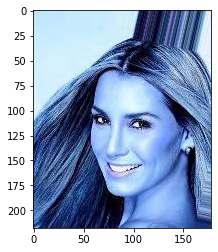

In [48]:
plt.imshow(img/255)
plt.show()

In [49]:
img_pred = img_pred.reshape(img_pred.shape[1],img_pred.shape[2],img_pred.shape[3])
img_pred = img_pred * 255

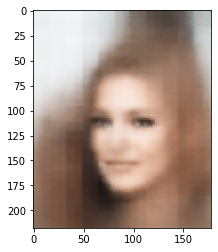

In [50]:
plt.imshow(img_pred/255)
plt.show()

In [51]:
cv2.imwrite("img_pred.jpg",img_pred)

True

In [52]:
cv2.imwrite("img.jpg",img)

True

In [53]:
test_gen = k_data_gen.flow_from_dataframe(dataframe=anno_data_pd[anno_data_pd.train_val_test == 'test'].iloc[0:10,:][["filename"]],
                                           directory=DATA_DIR + IMG_DIR,
                                           class_mode="input",
                                           batch_size=10,
                                           shuffle=True,
                                           seed=42,
                                           target_size=(img.shape[0],img.shape[1]))

Found 10 validated image filenames.


In [56]:
test_data = next(test_gen)

In [57]:
test_data_pred = complete_model.predict(test_data)

In [58]:
test_data_pred.shape

(10, 218, 178, 3)

In [59]:
for idx in range(10):
    img_original = test_data[0][idx,:,:,:]
    #img_original = img_original.reshape((img_original.shape[1],img_original.shape[2],img_original.shape[3]))
    #img_original = img_original * 255
    
    img_pred = test_data_pred[idx,:,:,:]
    #img_pred = img_array.reshape((img_pred.shape[1],img_pred.shape[2],img_pred.shape[3]))
    #img_pred = img_pred * 255
    
    plt.imsave("prediction/"+str(idx)+"_original.jpg",img_original)
    plt.imsave("prediction/"+str(idx)+"_predict.jpg",img_pred)

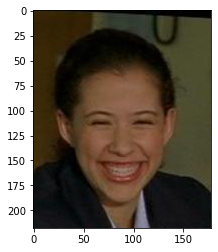

In [63]:
plt.imshow(img_original)
plt.show()

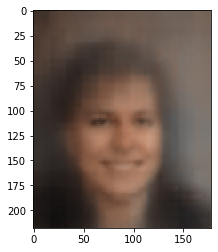

In [64]:
plt.imshow(img_pred)
plt.show()